## **Capstone MDS - XGBoost**

#### **_Integrantes:_**  

1. Evans Díaz   
1. Felipe Ojeda
1. Javier Cofre  
1. Luis Reinoso

In [39]:
# importar librerías
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint, uniform
from matplotlib.ticker import EngFormatter

In [40]:
# función cálculo R2, RMSE y MSE
def R2_RMSE(y_true, y_pred):
  # cálculo de R2 y RMSE
  r2 = r2_score(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  
  return print('R2:',r2), print('RMSE:',rmse), print('MSE:', mse)

## **_1. Lectura (carga) de los Datos_**

In [41]:
# importamos archivo
df = pd.read_csv('../Data/df_final_pay_des.csv')

In [42]:
# miramos el dataframe
df.head()

,crew_E2,crew_E3,crew_E4,day_10,day_11,day_12,day_13,day_14,day_15,day_16,...,CAT 798-AC_des,KOM-CHQ_des,KOM.960E5_des,Kom.930E-4_des,Kom.930E-4SE_des,Kom.930EN_des,Kom.930ER_des,Kom.930ER-MT_des,Kom.980E5_des,Komatsu AHS_des
0,False,False,True,False,False,False,False,False,False,False,...,-0.21334,-0.575556,2.735792,0.191462,0.563663,2.277691,0.101727,-0.035749,-2.98167,-0.101592
1,True,False,False,False,False,False,False,False,False,False,...,-0.21334,-0.575556,2.735792,0.191462,0.607062,2.277691,0.101727,-0.035749,-2.98167,-0.101592
2,False,False,True,False,False,False,False,False,False,False,...,-0.21334,-0.575556,2.735792,0.191462,0.520264,2.277691,0.101727,-0.035749,-2.98167,-0.101592
3,True,False,False,False,False,False,False,False,False,False,...,-0.21334,-0.575556,2.735792,-1.756724,0.607062,2.277691,0.101727,-0.035749,-2.98167,-0.101592
4,False,False,True,False,False,False,False,False,False,False,...,-0.21334,-0.575556,2.735792,0.191462,0.563663,2.277691,0.101727,-0.035749,-2.98167,-0.101592


In [43]:
# información general df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 86 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   crew_E2               1565 non-null   bool   
 1   crew_E3               1565 non-null   bool   
 2   crew_E4               1565 non-null   bool   
 3   day_10                1565 non-null   bool   
 4   day_11                1565 non-null   bool   
 5   day_12                1565 non-null   bool   
 6   day_13                1565 non-null   bool   
 7   day_14                1565 non-null   bool   
 8   day_15                1565 non-null   bool   
 9   day_16                1565 non-null   bool   
 10  day_17                1565 non-null   bool   
 11  day_18                1565 non-null   bool   
 12  day_19                1565 non-null   bool   
 13  day_2                 1565 non-null   bool   
 14  day_20                1565 non-null   bool   
 15  day_21               

## **_2 Preparación del DataFrame_**

In [44]:
# transformamos las variables bool a categorical y le asignamos 0 o 1
for col in df.columns:
  if df[col].dtype == 'bool':
     df[col] = df[col].astype('category').cat.codes
     df[col] = df[col].astype('category') # para que quede como category y no como int8

In [45]:
print('Nombre Columnas: ',df.columns)
print('Cantidad Columnas: ',len(df.columns))

Nombre Columnas:  Index(['crew_E2', 'crew_E3', 'crew_E4', 'day_10', 'day_11', 'day_12', 'day_13',
       'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_2',
       'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26',
       'day_27', 'day_28', 'day_29', 'day_3', 'day_30', 'day_31', 'day_4',
       'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'distance',
       'distance_down', 'distance_down_level', 'distance_up',
       'distance_up_level', 'lift_down', 'lift_down_level', 'lift_up',
       'lift_up_level', 'month_10', 'month_11', 'month_12', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'pay_original', 'shift_B', 'travel_time', 'year_2023',
       'year_2024', 'total_des', 'efectivo_des', 'mantencion_des',
       'mecanica_des', 'electrica_des', 'mant_excl_des', 'mec_excl_des',
       'elec_excl_des', 'som_excl_des', 'demora_des', 'r_prog_des',
       'r_noprg_des', 'waiting_des', 'queued_des', '

In [46]:
# cálculamos la desviaicón estándar y la media de payload
std_y = df['pay_original'].std()
mean_y = df['pay_original'].mean()

print('Desviación Estándar:',std_y)
print('Media:',mean_y)

Desviación Estándar: 19865.315566014815
Media: 142292.45186568802


In [47]:
# estandarizamos las variables numéricas
col_num = df.drop('pay_original', axis=1).select_dtypes(include=['float64','int64']).columns

scaler = StandardScaler()
df[col_num] = scaler.fit_transform(df[col_num])

## **_3 XGBoost_**

In [48]:
# definimos el tamaño del set de test
test_size = 0.30

In [49]:
# separamos los datos en X e y
X = df.drop('pay_original', axis=1)
y = df['pay_original']

# dividimos los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42) 

In [50]:
# Crear el modelo XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', 
                             enable_categorical=True,
                             random_state=42)

In [51]:
# Entrenar el modelo
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [52]:
# Realizar predicciones en el conjunto de entrenamiento
predictions_train = xgb_model.predict(X_train)

In [53]:
# resultados de R2, RMSE y MSE
R2_RMSE(y_train, predictions_train)

R2: 0.9997223384386877
RMSE: 328.71537652940555
MSE: 108053.79876686887


(None, None, None)

In [54]:
# Realizar predicciones con el modelo entrenado
predictions_test = xgb_model.predict(X_test)

In [55]:
# resultado de R2, RMSE y MSE
R2_RMSE(y_test, predictions_test)

R2: 0.6547468699700901
RMSE: 11847.327235636954
MSE: 140359162.62826514


(None, None, None)

## _4 Optimización del Modelo_ 

### _4.1 Selección de Variables (LassoCV)_

In [56]:
# buscamos alpha optimo con LassoCV
alpha_values = np.linspace(0.01, 300, 30000)

# Crea un objeto LassoCV
lasso_cv = LassoCV(alphas=alpha_values, cv=5)

# Ajusta el modelo a los datos de entrenamiento
lasso_cv.fit(X_train, y_train)

# Valor óptimo de alpha
best_alpha = lasso_cv.alpha_

# Evalúa el modelo en el conjunto de prueba
score = lasso_cv.score(X_test, y_test)

print(f"Mejor valor de alpha: {best_alpha}")
print(f"Puntuación en el conjunto de prueba: {score}")

/opt/miniconda3/envs/py312/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37049510.37113953, tolerance: 34731363.88867143
  model = cd_fast.enet_coordinate_descent_gram(
/opt/miniconda3/envs/py312/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52910828.95100403, tolerance: 34731363.88867143
  model = cd_fast.enet_coordinate_descent_gram(
/opt/miniconda3/envs/py312/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67930140.80010986, tolerance: 34731363.88867143
  model = cd_fast.enet_coordinate_descent_gram(
/opt/miniconda3/envs/py312/lib/python3.12/site-packages

Mejor valor de alpha: 161.51999999999998
Puntuación en el conjunto de prueba: 0.6806062663761169


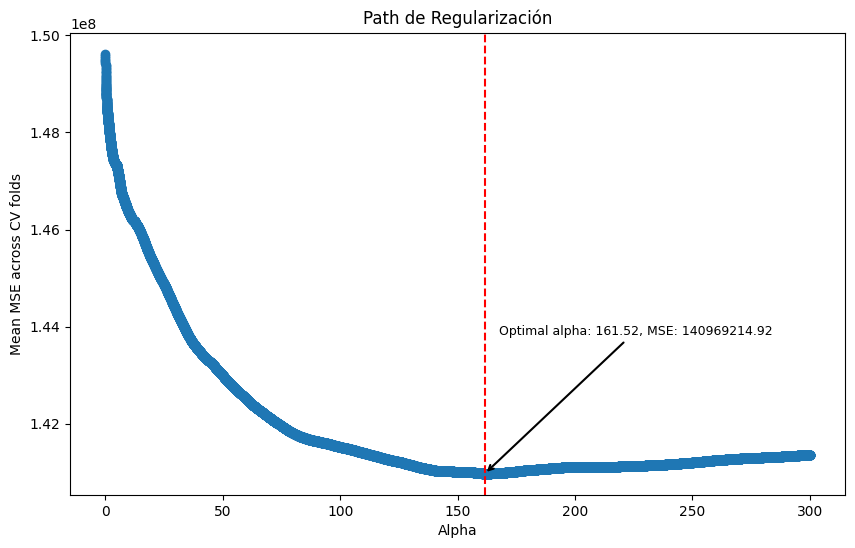

In [57]:
# Graficar MSE vs. Alpha
plt.figure(figsize=(10,6))
plt.plot(lasso_cv.alphas_, np.mean(lasso_cv.mse_path_, axis=1), '-o')
plt.xlabel('Alpha')
plt.ylabel('Mean MSE across CV folds')
plt.title('Path de Regularización')
plt.axvline(lasso_cv.alpha_, color='red', linestyle='--')

# Anotar el valor óptimo de alpha en el gráfico
plt.annotate(f'Optimal alpha: {lasso_cv.alpha_:.2f}, MSE: {np.min(np.mean(lasso_cv.mse_path_, axis=1)):.2f}',
             xy=(lasso_cv.alpha_, np.min(np.mean(lasso_cv.mse_path_, axis=1))),
             xycoords='data', xytext=(10,100), 
             textcoords='offset points',
             arrowprops=dict(arrowstyle="->", lw=1.5),
             fontsize=9)

plt.show()

In [58]:
# Aplicar Lasso para la selección de características
lasso = Lasso(alpha=lasso_cv.alpha_)  
lasso.fit(X_train, y_train)

# Seleccionar las características que tienen coeficientes no nulos
selected_features = X_train.columns[lasso.coef_ != 0]

print("Características seleccionadas:")
print(selected_features)


Características seleccionadas:
Index(['crew_E2', 'crew_E4', 'distance', 'distance_down_level',
       'distance_up_level', 'lift_down', 'month_3', 'month_6', 'month_7',
       'month_9', 'shift_B', 'electrica_des', 'mant_excl_des', 'mec_excl_des',
       'som_excl_des', 'r_prog_des', 'r_noprg_des', 'waiting_des',
       'queued_des', 'payload_des', 'expected_time_des', 'CAT 797-F_des',
       'CAT 798-AC_des', 'KOM-CHQ_des', 'Kom.930E-4_des', 'Kom.930ER_des',
       'Kom.930ER-MT_des', 'Komatsu AHS_des'],
      dtype='object')


In [59]:
len(selected_features)

28

> Volvemos ajustar el modelo con las variables seleccionadas

In [60]:
# separamos los datos en train y test
X_lasso= df[selected_features]
y_lasso = df['pay_original']

# dividimos los datos en train y test
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X_lasso, y_lasso, test_size=test_size, random_state=42)

In [61]:
# Inicializar el regresor AdaBoost
xgb_model_lasso = xgb.XGBRegressor(objective='reg:squarederror', 
                                   enable_categorical=True,
                                   random_state=42)

In [62]:
# Entrenar el modelo AdaBoost
xgb_model_lasso.fit(X_train_lasso, y_train_lasso)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

#### 4.1.1 Predicciones en el conjunto de entrenamiento

In [63]:
# Realizar predicciones con el modelo entrenado
predictions_lasso_train = xgb_model_lasso.predict(X_train_lasso)

In [64]:
# Evaluar la precisión del modelo
mse = mean_squared_error(y_train_lasso, predictions_lasso_train)
print(f'Mean Squared Error of AdaBoost Regressor: {mse:.2f}')

Mean Squared Error of AdaBoost Regressor: 198579.45


In [65]:
# resultado de R2, RMSE y MSE
R2_RMSE(y_train_lasso, predictions_lasso_train)

R2: 0.9994897182644388
RMSE: 445.6225414111489
MSE: 198579.4494137311


(None, None, None)

#### 4.1.2 Predicciones en el conjunto de testeo

In [66]:
# Realizar predicciones con el modelo entrenado
predictions_lasso_test = xgb_model_lasso.predict(X_test_lasso)

In [67]:
# Evaluar la precisión del modelo
mse = mean_squared_error(y_test_lasso, predictions_lasso_test)
print(f'Mean Squared Error of AdaBoost Regressor: {mse:.2f}')

Mean Squared Error of AdaBoost Regressor: 157588174.33


In [68]:
# resultado de R2, RMSE y MSE
R2_RMSE(y_test_lasso, predictions_lasso_test)

R2: 0.6123672340103581
RMSE: 12553.412855694609
MSE: 157588174.32551867


(None, None, None)

### _4.2 Optimización de Hiperparámetros_

In [69]:
# Definir los hiperparámetros para la búsqueda
param_dist_xgb = {
    'n_estimators': randint(50, 500),
    'learning_rate': uniform(0.01, 0.6),
    'subsample': uniform(0.3, 0.7),
    'max_depth': randint(1, 20),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),  # L1 regularization term
    'reg_lambda': uniform(1, 4)  # L2 regularization term
}

# Crear el modelo XGBoost
xgb_model_hip= xgb.XGBRegressor(objective='reg:squarederror',
                             enable_categorical=True,
                             random_state=42)

# Crear la búsqueda de hiperparámetros
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model_hip,
    param_distributions=param_dist_xgb,
    n_iter=100,
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

# Ajustar el modelo
random_search_xgb.fit(X_train_lasso, y_train_lasso)

# Obtener los mejores hiperparámetros
best_params_xgb = random_search_xgb.best_params_
print("Best parameters for XGBoost: ", best_params_xgb)


/opt/miniconda3/envs/py312/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for XGBoost:  {'colsample_bytree': 0.8005575058716043, 'gamma': 0.35403628889802274, 'learning_rate': 0.02235069657748147, 'max_depth': 2, 'n_estimators': 393, 'reg_alpha': 0.8324426408004217, 'reg_lambda': 1.8493564427131046, 'subsample': 0.42727747704497043}


In [70]:
# Crear el modelo XGBoost con los mejores hiperparámetros
xgb_model_best = xgb.XGBRegressor(objective='reg:squarederror',
                             enable_categorical=True,
                             random_state=42,
                             **best_params_xgb)

In [71]:
# Entrenar el modelo con los mejores hiperparámetros
xgb_model_best.fit(X_train_lasso, y_train_lasso,
                   eval_set=[(X_test_lasso, y_test_lasso)],
                   early_stopping_rounds=10,
                   verbose=False)

/opt/miniconda3/envs/py312/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8005575058716043, device=None,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, feature_types=None, gamma=0.35403628889802274,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02235069657748147,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=393, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [72]:
# Realizar predicciones en el conjunto de entrenamiento
train_predictions = xgb_model_best.predict(X_train_lasso)

# Realizar predicciones en el conjunto de prueba
test_predictions = xgb_model_best.predict(X_test_lasso)

In [73]:
# Evaluar el modelo en el conjunto de entrenamiento
train_r2 = r2_score(y_train_lasso, train_predictions)
train_mse = mean_squared_error(y_train_lasso, train_predictions)
train_rmse = np.sqrt(train_mse)

print(f"R2 en el conjunto de entrenamiento: {train_r2:.2f}")
print(f"RMSE en el conjunto de entrenamiento: {train_rmse:.2f}")

R2 en el conjunto de entrenamiento: 0.70
RMSE en el conjunto de entrenamiento: 10733.93


In [74]:
# Evaluar el modelo en el conjunto de prueba
test_r2 = r2_score(y_test_lasso, test_predictions)
test_mse = mean_squared_error(y_test_lasso, test_predictions)
test_rmse = np.sqrt(test_mse)

print(f"R2 en el conjunto de prueba: {test_r2:.2f}")
print(f"RMSE en el conjunto de prueba: {test_rmse:.2f}")

R2 en el conjunto de prueba: 0.67
RMSE en el conjunto de prueba: 11580.52
